In [12]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

from utils.conn_data import load_pickle

warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [13]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), "src", 'data', 'utils', 'fredmd_description.csv'), sep=';')

# fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam", "dynotears"]
fs_methods = ["lasso_rollingcluster", "var-lingam_rollingcluster"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [15]:
all_parents = []
for fs in fs_methods:
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]
        obj = load_pickle(path=file)
        parents_of_target_df = obj["parents_of_target"]

        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        all_parents.append(parents_of_target_df)
all_parents_df = pd.concat(all_parents)

In [16]:
ticker = "SPY"
etf_df = all_parents_df[(all_parents_df["etf"] == ticker)]
etf_df.loc[:, "date"] = [dtref.strftime("%Y-%m-%d") for dtref in etf_df["date"]]

etf_df = etf_df.sort_values(by=["date"])
all_scores = []
for fs in etf_df["fs"].unique():
    fs_etf_df = etf_df[etf_df["fs"] == fs]

    score = []
    for i, date in enumerate(fs_etf_df["date"].unique()):
        if i == 0:
            F_t = F_tm1 = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
            s = 0
        else:
            F_t = set(fs_etf_df.loc[fs_etf_df["date"] == date]["cluster"].dropna().values)
            s = len(F_tm1.intersection(F_t)) / len(F_tm1.union(F_t)) if len(F_tm1.union(F_t)) != 0 else np.nan
            F_tm1 = F_t
        score.append({"date": date, "score": s})
    score_df = pd.DataFrame(score)
    score_df["fs"] = fs

    melt_score_df = score_df.melt(["date", "fs"])
    all_scores.append(melt_score_df)
all_scores_df = pd.concat(all_scores).drop("variable", axis=1)

In [17]:
all_scores_df.groupby(["fs"])[["value"]].mean().sort_values(by=["value"], ascending=False)

,value
fs,
lasso_rollingcluster,0.058588
var-lingam_rollingcluster,0.051020


Text(0, 0.5, 'Frequency')

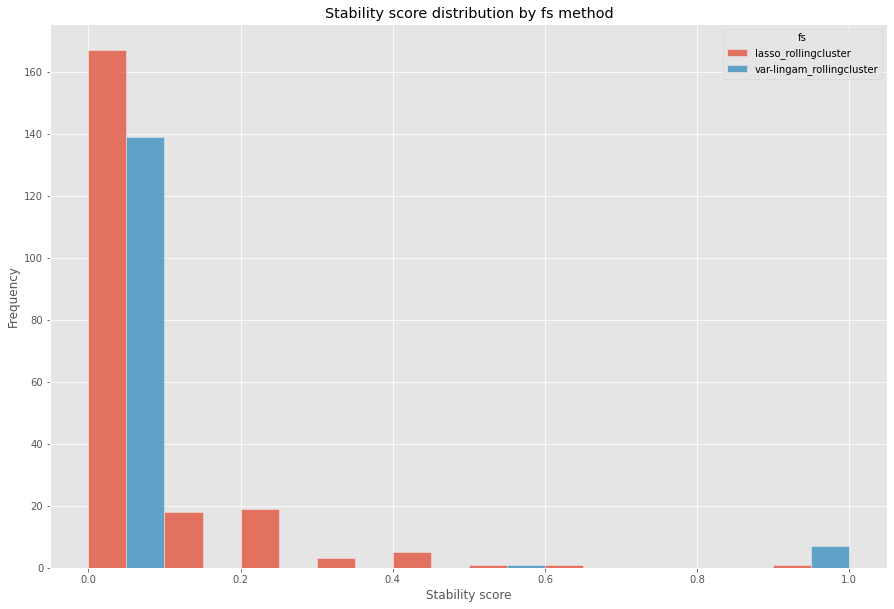

In [18]:
# seaborn sobrebosed histograms by fs group on the smae plot
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=all_scores_df, x="value", hue="fs", multiple="dodge", ax=ax)
ax.set_title("Stability score distribution by fs method")
ax.set_xlabel("Stability score")
ax.set_ylabel("Frequency")